In [1]:
import numpy as np
import pandas as pd
import re

from pathlib import Path

In [2]:
!ls

aa_snp_sig_counts.csv                 explore_snps2.ipynb
classify_clade_snps.ipynb             process_pangolin_lineages.ipynb
clean_locations.ipynb                 rainbow_entropy_plot.ipynb
clean_locations2.ipynb                snp_mapping.ipynb
dna_snp_map.csv                       spike_rainbow.png
embed_sequence_counts_into_tree.ipynb valid_aa_snps.csv
explore_snps.ipynb                    valid_dna_snps.csv


In [3]:
data_dir = Path('/Volumes/GoogleDrive/My Drive/covid_data')

In [4]:
# Load AA SNP data
aa_snp_path = data_dir / 'aa_snp'
aa_snp_df = pd.DataFrame()
for f in aa_snp_path.glob('*.csv'):
    aa_snp_df = pd.concat([aa_snp_df, pd.read_csv(f)], ignore_index=True)
aa_snp_df

,taxon,gene,pos,ref,alt
0,hCoV-19/USA/FL-BPHL-046/2020|EPI_ISL_436550|20...,ORF1a,3643,L,F
1,hCoV-19/USA/FL-BPHL-046/2020|EPI_ISL_436550|20...,ORF1b,313,P,L
2,hCoV-19/USA/FL-BPHL-046/2020|EPI_ISL_436550|20...,ORF1b,578,V,L
3,hCoV-19/USA/FL-BPHL-046/2020|EPI_ISL_436550|20...,S,613,D,G
4,hCoV-19/USA/FL-BPHL-046/2020|EPI_ISL_436550|20...,ORF3a,56,Q,H
...,...,...,...,...,...
171621,hCoV-19/Netherlands/Gelderland_48/2020|EPI_ISL...,ORF1b,742,H,Q
171622,hCoV-19/Netherlands/Gelderland_48/2020|EPI_ISL...,S,613,D,G
171623,hCoV-19/Netherlands/Gelderland_48/2020|EPI_ISL...,ORF7a,40,E,_
171624,hCoV-19/Netherlands/Gelderland_48/2020|EPI_ISL...,N,202,R,K


In [5]:
genes_df = pd.read_csv(data_dir / 'genes.csv')
genes_df

,index,gene,locus_tag,db_xref,codon_start,start,end,protein_coding
0,1,5'UTR,NaN,NaN,NaN,1,265,0
1,2,ORF1a,NaN,NaN,1.0,266,13468,1
2,3,ORF1b,NaN,NaN,NaN,13468,21555,1
3,4,S,NaN,NaN,1.0,21563,25384,1
4,5,ORF3a,NaN,NaN,1.0,25393,26220,1
5,6,E,NaN,NaN,1.0,26245,26472,1
6,7,M,NaN,NaN,1.0,26523,27191,1
7,8,ORF6,NaN,NaN,1.0,27202,27387,1
8,9,ORF7a,NaN,NaN,1.0,27394,27759,1
9,10,ORF7b,NaN,NaN,1.0,27756,27887,1


# Try on Spike first, AA only

In [6]:
# Get all AA SNPs on spike
gene_snps = aa_snp_df.loc[aa_snp_df['gene'] == 'S', :]
gene_snps

,taxon,gene,pos,ref,alt
3,hCoV-19/USA/FL-BPHL-046/2020|EPI_ISL_436550|20...,S,613,D,G
9,hCoV-19/USA/FL-BPHL-047/2020|EPI_ISL_436551|20...,S,613,D,G
15,hCoV-19/USA/FL-BPHL-048/2020|EPI_ISL_436552|20...,S,613,D,G
20,hCoV-19/USA/FL-BPHL-051/2020|EPI_ISL_436555|20...,S,613,D,G
26,hCoV-19/USA/LA-BIE-093/2020|EPI_ISL_436960|202...,S,613,D,G
...,...,...,...,...,...
171600,hCoV-19/Netherlands/Gelderland_44/2020|EPI_ISL...,S,613,D,G
171605,hCoV-19/Netherlands/Gelderland_45/2020|EPI_ISL...,S,613,D,G
171612,hCoV-19/Netherlands/Gelderland_46/2020|EPI_ISL...,S,613,D,G
171617,hCoV-19/Netherlands/Gelderland_47/2020|EPI_ISL...,S,613,D,G


In [7]:
# Make a unique list of SNPs on spike
gene_snp_map = gene_snps.groupby(['pos', 'ref', 'alt'], as_index=False)['taxon'].count()

# Filter out low counts to make the matrix multiplication easier
gene_snp_map = gene_snp_map.loc[gene_snp_map['taxon'] > 10].reset_index(drop=True)

# Remove ambiguous AAs
gene_snp_map = gene_snp_map.loc[gene_snp_map['alt'] != '*'].reset_index(drop=True)

# Make index column
gene_snp_map['ind'] = np.arange(0, len(gene_snp_map))
# Set index for quick lookups
gene_snp_map = gene_snp_map.set_index(['pos', 'ref', 'alt'])

gene_snp_map

,,,taxon,ind
pos,ref,alt,,
4,L,F,246,0
7,L,V,30,1
17,L,F,95,2
20,R,I,153,3
21,T,I,14,4
...,...,...,...,...
1246,C,F,12,108
1251,S,P,43,109
1262,P,L,275,110


In [8]:
gene_snp_map.loc[613, 'D', 'G']['ind']

57

In [9]:
# Make a matrix, where rows = taxons and cols = SNP IDs
gene_snps['snp_str'] = gene_snps['pos'].astype(str) + '|' + gene_snps['ref'] + '|' + gene_snps['alt']
gene_snps

/Users/chena/miniconda3/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,taxon,gene,pos,ref,alt,snp_str
3,hCoV-19/USA/FL-BPHL-046/2020|EPI_ISL_436550|20...,S,613,D,G,613|D|G
9,hCoV-19/USA/FL-BPHL-047/2020|EPI_ISL_436551|20...,S,613,D,G,613|D|G
15,hCoV-19/USA/FL-BPHL-048/2020|EPI_ISL_436552|20...,S,613,D,G,613|D|G
20,hCoV-19/USA/FL-BPHL-051/2020|EPI_ISL_436555|20...,S,613,D,G,613|D|G
26,hCoV-19/USA/LA-BIE-093/2020|EPI_ISL_436960|202...,S,613,D,G,613|D|G
...,...,...,...,...,...,...
171600,hCoV-19/Netherlands/Gelderland_44/2020|EPI_ISL...,S,613,D,G,613|D|G
171605,hCoV-19/Netherlands/Gelderland_45/2020|EPI_ISL...,S,613,D,G,613|D|G
171612,hCoV-19/Netherlands/Gelderland_46/2020|EPI_ISL...,S,613,D,G,613|D|G
171617,hCoV-19/Netherlands/Gelderland_47/2020|EPI_ISL...,S,613,D,G,613|D|G


In [10]:
gene_snp_list = gene_snps.groupby('taxon')['snp_str'].agg(list)
gene_snp_list

taxon
hCoV-10/Canada/AB5/2020|EPI_ISL_435347|2020-04                                                         [613|D|G]
hCoV-19//Estonia/ChVir4266/2020|EPI_ISL_457722|2020-03                                                 [613|D|G]
hCoV-19/Algeria/G0638_2264/2020|EPI_ISL_418241|2020-03-02                                              [613|D|G]
hCoV-19/Algeria/G0640_2265/2020|EPI_ISL_418242|2020-03-08                                              [613|D|G]
hCoV-19/Algeria/G0860_2262/2020|EPI_ISL_420037|2020-03-02                                              [613|D|G]
                                                                                     ...                        
hCoV-19/mouse/Harbin/HRB-26m/2020|EPI_ISL_459910|2020-04-19    [497|Q|H, 673|Y|_, 674|Q|K, 675|T|K, 676|Q|K, ...
hCov-19/Canada/AG1/2020|EPI_ISL_435344|2020-04                                                         [613|D|G]
hCov-19/Canada/AG6/2020|EPI_ISL_435343|2020-04                                            

In [11]:
snp_mat = np.zeros((len(gene_snp_list), len(gene_snp_map)))

for i, snp_list in enumerate(gene_snp_list.values):
    if i % 1000 == 0:
        print(i)
    for snp in snp_list:
        if type(snp) is not str:
            continue
        snp_split = snp.split('|')
        
        try:
            snp_ind = gene_snp_map.loc[int(snp_split[0]), snp_split[1], snp_split[2]]['ind']
            snp_mat[i, snp_ind] = 1
        except:
            continue
snp_mat

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
snp_mat.shape

(28169, 113)

In [13]:
from scipy.cluster.hierarchy import linkage, fcluster

In [14]:
lnk = linkage(snp_mat)
lnk

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [2.00000000e+00, 2.81690000e+04, 0.00000000e+00, 3.00000000e+00],
       [3.00000000e+00, 2.81700000e+04, 0.00000000e+00, 4.00000000e+00],
       ...,
       [9.59500000e+03, 5.63330000e+04, 1.00000000e+00, 2.10000000e+01],
       [5.63300000e+04, 5.63340000e+04, 1.41421356e+00, 2.81580000e+04],
       [5.61060000e+04, 5.63350000e+04, 1.41421356e+00, 2.81690000e+04]])

In [15]:
clust = fcluster(lnk, 1)
clust

array([174, 174, 174, ..., 174, 174, 174], dtype=int32)

In [16]:
np.unique(clust)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [17]:
len(clust)

28169

In [18]:
taxon_cluster = pd.DataFrame(gene_snp_list)
taxon_cluster['cluster'] = clust
taxon_cluster

,snp_str,cluster
taxon,,
hCoV-10/Canada/AB5/2020|EPI_ISL_435347|2020-04,[613|D|G],174
hCoV-19//Estonia/ChVir4266/2020|EPI_ISL_457722|2020-03,[613|D|G],174
hCoV-19/Algeria/G0638_2264/2020|EPI_ISL_418241|2020-03-02,[613|D|G],174
hCoV-19/Algeria/G0640_2265/2020|EPI_ISL_418242|2020-03-08,[613|D|G],174
hCoV-19/Algeria/G0860_2262/2020|EPI_ISL_420037|2020-03-02,[613|D|G],174
...,...,...
hCoV-19/mouse/Harbin/HRB-26m/2020|EPI_ISL_459910|2020-04-19,"[497|Q|H, 673|Y|_, 674|Q|K, 675|T|K, 676|Q|K, ...",173
hCov-19/Canada/AG1/2020|EPI_ISL_435344|2020-04,[613|D|G],174
hCov-19/Canada/AG6/2020|EPI_ISL_435343|2020-04,[613|D|G],174


In [19]:
taxon_cluster.sort_values('cluster')

,snp_str,cluster
taxon,,
hCoV-19/England/CAMB-76C3E/2020|EPI_ISL_438285|2020-03-29,"[50|T|I, 53|L|F, 613|D|G, 1103|V|L]",1
hCoV-19/England/CAMB-7667C/2020|EPI_ISL_439394|2020-03-29,"[50|T|I, 53|L|F, 613|D|G, 1103|V|L]",1
hCoV-19/England/NORW-EB5DF/2020|EPI_ISL_457446|2020-05-01,"[50|T|I, 53|L|F, 613|D|G, 1103|V|L]",1
hCoV-19/England/NORW-EB50C/2020|EPI_ISL_457439|2020-05-01,"[50|T|I, 53|L|F, 613|D|G, 1103|V|L]",1
hCoV-19/England/CAMB-7668B/2020|EPI_ISL_438490|2020-03-30,"[50|T|I, 53|L|F, 613|D|G, 1103|V|L]",1
...,...,...
hCoV-19/England/CAMB-1AF66A/2020|EPI_ISL_448089|2020-05-06,"[140|L|F, 141|G|F, 142|V|F, 143|Y|F, 613|D|G]",229
hCoV-19/England/NORW-EC3E3/2020|EPI_ISL_457522|2020-05-12,"[140|L|F, 141|G|F, 142|V|F, 143|Y|F, 613|D|G]",229
hCoV-19/USA/CA-SR0187/2020|EPI_ISL_437593|2020-03-25,"[140|L|F, 141|G|F, 142|V|F, 143|Y|F, 613|D|G]",229


In [20]:
spike_aa = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT_'

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# plt.matshow(np.array([['A', 'B', 'C'], ['A', 'B', 'C'], ['A', 'A', 'A']]))

In [23]:
np.zeros((10, 5, 3))

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0.,

In [24]:
shing_aa_colors = {
    'R': '#E60606',
    'K': '#C64200',
    'Q': '#FF6600',
    'N': '#CCFF99',
    'E': '#FFCC00',
    'D': '#FFCC99',
    'H': '#FFFF99',
    'P': '#FFFF00',
    'Y': '#CCFFCC',
    'W': '#00FF00',
    'S': '#FF9900',
    'T': '#00FF99',
    'G': '#CC99FF',
    'A': '#CCFFFF',
    'M': '#99CCFF',
    'C': '#00FFFF',
    'F': '#00CCFF',
    'L': '#3366FF',
    'V': '#0000FF',
    'I': '#000080',
    '_': '#FF0000'
}
shing_aa_colors

{'R': '#E60606',
 'K': '#C64200',
 'Q': '#FF6600',
 'N': '#CCFF99',
 'E': '#FFCC00',
 'D': '#FFCC99',
 'H': '#FFFF99',
 'P': '#FFFF00',
 'Y': '#CCFFCC',
 'W': '#00FF00',
 'S': '#FF9900',
 'T': '#00FF99',
 'G': '#CC99FF',
 'A': '#CCFFFF',
 'M': '#99CCFF',
 'C': '#00FFFF',
 'F': '#00CCFF',
 'L': '#3366FF',
 'V': '#0000FF',
 'I': '#000080',
 '_': '#FF0000'}

In [25]:
# Convert hex into RGB
shing_aa_colors_rgb = {}
for res, hexcode in shing_aa_colors.items():
    # Chop off pound
    hexcode = hexcode[1:]
    shing_aa_colors_rgb[res] = tuple([
        # Get slice and convert to float
        int(hexcode[i:i+2], 16) / 255
        # Split into three strings (R, G, B)
        for i in range(0, 6, 2)
    ])
    
shing_aa_colors_rgb

{'R': (0.9019607843137255, 0.023529411764705882, 0.023529411764705882),
 'K': (0.7764705882352941, 0.25882352941176473, 0.0),
 'Q': (1.0, 0.4, 0.0),
 'N': (0.8, 1.0, 0.6),
 'E': (1.0, 0.8, 0.0),
 'D': (1.0, 0.8, 0.6),
 'H': (1.0, 1.0, 0.6),
 'P': (1.0, 1.0, 0.0),
 'Y': (0.8, 1.0, 0.8),
 'W': (0.0, 1.0, 0.0),
 'S': (1.0, 0.6, 0.0),
 'T': (0.0, 1.0, 0.6),
 'G': (0.8, 0.6, 1.0),
 'A': (0.8, 1.0, 1.0),
 'M': (0.6, 0.8, 1.0),
 'C': (0.0, 1.0, 1.0),
 'F': (0.0, 0.8, 1.0),
 'L': (0.2, 0.4, 1.0),
 'V': (0.0, 0.0, 1.0),
 'I': (0.0, 0.0, 0.5019607843137255),
 '_': (1.0, 0.0, 0.0)}

In [26]:
taxon_cluster = taxon_cluster.reset_index()

In [27]:
taxon_cluster

,taxon,snp_str,cluster
0,hCoV-10/Canada/AB5/2020|EPI_ISL_435347|2020-04,[613|D|G],174
1,hCoV-19//Estonia/ChVir4266/2020|EPI_ISL_457722...,[613|D|G],174
2,hCoV-19/Algeria/G0638_2264/2020|EPI_ISL_418241...,[613|D|G],174
3,hCoV-19/Algeria/G0640_2265/2020|EPI_ISL_418242...,[613|D|G],174
4,hCoV-19/Algeria/G0860_2262/2020|EPI_ISL_420037...,[613|D|G],174
...,...,...,...
28164,hCoV-19/mouse/Harbin/HRB-26m/2020|EPI_ISL_4599...,"[497|Q|H, 673|Y|_, 674|Q|K, 675|T|K, 676|Q|K, ...",173
28165,hCov-19/Canada/AG1/2020|EPI_ISL_435344|2020-04,[613|D|G],174
28166,hCov-19/Canada/AG6/2020|EPI_ISL_435343|2020-04,[613|D|G],174
28167,hCov-19/Oman/RESP-20-4153/2020|EPI_ISL_457988|...,[613|D|G],174


In [28]:
# Make the bitmap row for the reference (Spike AA)
reference_rgb = np.array([
    list(shing_aa_colors_rgb[char])
    for char in list(spike_aa)
])
print(reference_rgb.shape)
reference_rgb

(1274, 3)


array([[0.6, 0.8, 1. ],
       [0. , 0.8, 1. ],
       [0. , 0. , 1. ],
       ...,
       [0.8, 1. , 0.8],
       [0. , 1. , 0.6],
       [1. , 0. , 0. ]])

In [31]:
# Make bitmap matrix. (N x M x 3), where N = number or rows (taxons), M = columns (gene coordinates),
# and 3 = tuple of (R, G, B)
# bitmat = np.zeros((len(taxon_cluster), len(spike_aa), 3))
bitmat = np.repeat(reference_rgb, len(taxon_cluster), axis=0)
bitmat = np.reshape(bitmat, (len(taxon_cluster), 1274, 3), order='F')
bitmat.shape

(28169, 1274, 3)

In [33]:
bitmat = np.ones((len(taxon_cluster), len(spike_aa), 3))
bitmat.shape

(28169, 1274, 3)

In [34]:
bitmat

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [35]:
# For each row:
for i, row in taxon_cluster.iterrows():
    if i % 5000 == 0:
        print(i)
    for snp in row['snp_str']:
        if type(snp) is not str:
            continue
        
        snp_split = snp.split('|')
        
        if snp_split[2] == '*':
            continue
        
        bitmat[i, int(snp_split[0])] = np.array(shing_aa_colors_rgb[snp_split[2]])

bitmat        

0
5000
10000
15000
20000
25000


array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

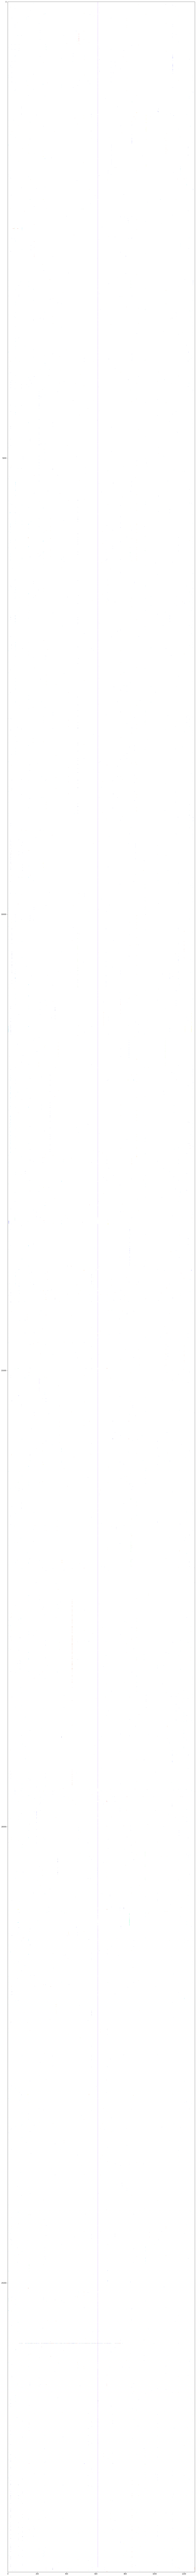

In [37]:
fig, ax = plt.subplots(1, 1)
# Default DPI is 100
# 28169 pixels / 100 pixels/inch = 281 inches
# Try to keep it rectangular, so set width to 300
# fig.set_size_inches(300, 282)
# Ok, that crashed my computer
# Make it 50, 100? And dont display here
fig.set_size_inches(20, 282)

# aspect='auto' means pixels can be rectangular, not just square
ax.imshow(bitmat, aspect='auto')

fig.savefig('spike_rainbow_clean.png', dpi=100)

plt.show()